**<h1>Glasses or No Glasses distributed (Numerical Dataset)</h1>**

In this notebook we will try to face the [Glasses or No Glasses](https://www.kaggle.com/jeffheaton/glasses-or-no-glasses) challenge by Kaggle in a distributed way, mainly using [PySpark](https://spark.apache.org/docs/latest/api/python/index.html), a Python interface for Apache Spark. The challenge provides two datasets, a numerical one and an image one. We will deal with the numerical dataset, using it to train a MLP.<br>
Refer to [this notebook](https://github.com/flaviofuria/GlassesOrNoGlasses/blob/main/glasses_no_glasses.ipynb), in which we faced the challenge (using both the dataset) with the classic data analysis/machine learning tools, to understand all the analysis, the reasoning and the choice of the network architecture. For the distributed version of the CNN applied on the image dataset, refer to [this notebook](https://github.com/flaviofuria/GlassesOrNoGlasses/blob/main/pyspark_images.ipynb) instead.

---
First we need some minutes to install [Elephas](https://github.com/maxpumperla/elephas), an extension of [Keras](https://keras.io/) that brings deep learning to Spark.

In [ ]:
!pip -q install elephas
!pip -q install tensorflow==2.6.0
!pip -q install keras==2.6.0

**<h4>Running Spark</h4>**

The following steps are required to run Spark.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xf spark-3.0.3-bin-hadoop2.7.tgz

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.0.3-bin-hadoop2.7"

!pip install -q findspark
import findspark
findspark.init("spark-3.0.3-bin-hadoop2.7")
findspark.find()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

**<h4>Downloading the data</h4>**


Now we download the data using the Kaggle API. To do so, we replace `KAGGLE_USERNAME` and `KAGGLE_KEY` variables with our Kaggle credentials. Then, we unzip the data.

In [ ]:
os.environ['KAGGLE_USERNAME'] = "xxxxxxxxxxxx"                     
os.environ['KAGGLE_KEY'] = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

!kaggle datasets download -d jeffheaton/glasses-or-no-glasses
!unzip -o -q /content/glasses-or-no-glasses.zip

100% 6.11G/6.11G [02:05<00:00, 36.8MB/s]
100% 6.11G/6.11G [02:05<00:00, 52.2MB/s]


We delete the stuff we don't need anymore, in order to save some space.

In [ ]:
!rm glasses-or-no-glasses.zip
!rm spark-3.0.3-bin-hadoop2.7.tgz
!rm -r sample_data

**<h4>Reproducibility</h4>**

Next, we set all the `seed` variables, in order to allow reproducibility of our experiments.

In [ ]:
seed = 0

os.environ["PYTHONHASHSEED"] = "0"

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

import tensorflow as tf
tf.random.set_seed(seed)

**<h4>Downloading our own labels</h4>**

We can start to get all the data we need, starting from labels. Being that the available labels in the original dataset were wrong and incomplete, we decided to write our own label structure. We download it from the project Github repository and store them as a `Spark DataFrame`, specifying the `schema`, i.e. the structure of the DataFrame we want to create.

In [ ]:
correct_labels_url = "https://raw.githubusercontent.com/flaviofuria/GlassesOrNoGlasses/main/labels.csv"
spark.sparkContext.addFile(correct_labels_url)

from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, ArrayType
schema = StructType([StructField("index", IntegerType(), False), StructField("label", DoubleType(), True)])

from pyspark import SparkFiles
labels_df = spark.read.csv(SparkFiles.get("labels.csv"), header=True, schema=schema)

In [ ]:
labels_df.limit(5).toPandas()

,index,label
0,1,0.0
1,2,1.0
2,3,1.0
3,4,0.0
4,5,0.0


**<h4>Creating the Dataset</h4>**

Next, we import and store the dataset: being provided in two .csv files, we create two Spark DataFrames, specifying the schema for both of them: we store the `id` as `IntegerType()`, the `512` features columns and the labels as `DoubleType()`.

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType
features_schema = [StructField("v"+str(i), DoubleType(), True) for i in range(1, 513)]
features_schema.insert(0, StructField("id", IntegerType(), False))
features_schema.insert(514, StructField("label", DoubleType(), True))
schema = StructType(features_schema)

train_df = spark.read.format("csv").option("header", "true").schema(schema).load("train.csv")
test_df = spark.read.format("csv").option("header", "true").schema(schema).load("test.csv")

df = train_df.select(train_df.columns[:-1]).union(test_df.select(test_df.columns[:-1]))

At this point we need to join the train and test dataframes, because we need to join it with the labels dataframe and filter the samples with undefined labels.

In [ ]:
df = df.join(labels_df, df.id==labels_df.index, 'inner')
df = df.drop(df.index)
df = df.filter((df.label==1.0) | (df.label==0.0))

In [ ]:
df.limit(5).toPandas()

,id,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,...,v474,v475,v476,v477,v478,v479,v480,v481,v482,v483,v484,v485,v486,v487,v488,v489,v490,v491,v492,v493,v494,v495,v496,v497,v498,v499,v500,v501,v502,v503,v504,v505,v506,v507,v508,v509,v510,v511,v512,label
0,1,0.37797,-0.94808,0.01346,0.17893,0.37795,0.63571,0.13943,-0.25607,-0.39341,1.08947,-1.36048,-1.31529,0.36119,-0.62857,-1.65290,1.47167,-0.88741,-0.25942,-0.34414,-0.38914,0.38425,-0.50553,-0.09451,0.30568,-1.07570,-0.65924,1.10918,1.22234,-0.12479,0.50198,-0.63932,0.61505,1.16747,0.36921,-0.44398,0.46192,-0.83207,-0.74952,-0.40722,...,0.54072,-0.71995,1.11262,-0.11429,0.85618,0.17233,-1.06815,0.04569,-0.13031,2.07549,0.47934,0.69172,1.37139,0.45480,-0.96053,0.06319,0.09664,-0.34749,0.09889,-0.87606,0.82594,0.52841,0.84209,0.16771,0.59003,-0.22960,-0.04017,0.15554,-0.41569,0.68050,-0.03494,1.32443,-0.94570,0.02055,-1.23908,0.43507,1.08635,1.69027,0.61609,0.0
1,2,0.07609,-0.09774,0.39666,-0.39026,0.10606,0.52774,0.07105,0.33720,0.69917,-0.02842,-0.56431,0.42060,-0.47533,1.60025,-0.02106,-2.30193,-0.31614,-0.08050,0.85041,-0.10574,-0.33177,-1.32102,-0.22244,-0.52076,0.40012,-0.41339,-0.15176,1.02155,-0.52834,0.66718,0.54844,0.18323,0.28764,-0.80084,-0.85040,0.45097,0.88317,-1.13375,-1.85301,...,-0.25966,-1.19259,-0.71514,-0.08903,-0.58853,-0.20697,-0.77025,-1.21129,-0.67575,0.32509,-0.35147,-0.33581,-0.31505,-1.66721,0.40666,0.15053,-0.77809,0.35837,-1.10950,0.03764,-0.93728,-0.68952,-0.92334,-0.35401,-1.20552,1.10199,0.46268,0.85954,-0.48484,-0.54585,0.86624,-1.24953,-0.21511,-1.54146,1.04765,-1.24035,0.00866,-1.27640,-0.60496,1.0
2,3,1.19391,-0.68707,-0.68422,-0.36378,-0.60847,-0.40118,1.45432,0.00592,1.68940,-0.98205,0.67435,-1.27604,-1.37050,-0.91682,0.23617,0.53676,-0.26815,-0.66989,0.46076,-0.04117,1.34078,0.46545,-0.25943,-0.22918,-0.49346,-0.53558,0.69776,1.15477,0.01293,-0.86763,-0.08987,0.54660,0.09142,-0.21663,-0.28233,0.15426,-1.02164,-0.24342,-0.18844,...,0.91472,-0.29778,0.45507,0.03296,-0.79752,1.19759,-0.45417,0.15993,0.39516,-0.87621,0.05737,-0.99432,1.19910,0.78989,-0.13908,0.12384,0.38121,0.05699,-0.89445,-0.67448,-0.07669,-1.50409,0.07962,0.95116,0.72782,-0.88516,0.40735,0.10415,0.31639,-0.34801,-0.35893,0.02330,0.31548,-0.34923,-0.41772,-0.58175,-0.60177,0.43555,0.41982,1.0
3,4,1.34949,-0.31498,-1.30248,0.50278,1.66292,-1.06094,-0.70835,-0.24237,-0.15509,-0.04532,0.97349,-0.21032,-0.71143,0.59725,-0.51849,0.00126,1.22219,0.57160,0.41212,0.90077,-0.80797,-1.20564,1.40774,0.49080,-1.05429,0.26300,-0.03849,-0.66792,-0.29260,0.47713,0.44967,0.44411,-0.13465,-0.20365,0.52841,-0.47348,0.39295,0.67695,0.40861,...,0.65551,-0.17916,0.55700,1.84589,0.70722,-0.55871,-1.18265,0.82509,-0.50715,0.71948,-1.08462,-0.05607,0.86918,-0.11338,-0.73700,-0.12130,0.81417,-0.61391,-0.90671,1.09301,0.37716,1.06373,-0.62199,-0.21279,-0.43245,-0.28904,-0.25435,-0.20458,-0.00398,1.18449,0.23942,0.20774,0.81792,-0.74814,-0.62521,0.01689,0.83997,-0.46986,0.06755,0.0
4,5,-0.03512,-0.34196,0.14230,1.50513,-0.14364,0.49429,0.07823,-0.04356,0.42009,-0.88828,0.13601,0.26917,0.11973,0.04378,1.06879,0.10060,-0.83331,-0.64776,0.26461,0.65249,-0.41807,0.65920,0.11838,-0.00525,-0.74657,-0.97743,-0.71398,-0.08356,-0.82942,0.60474,0.12790,-0.41187,-2.18319,0.27367,0.54507,0.26555,0.67382,-0.24832,0.43397,...,0.90449,-0.51652,-0.11353,1.59131,-0.15053,-0.03551,0.02906,0.16957,0.62629,0.71465,-0.77525,0.46366,0.03279,-0.17744,0.32256,0.16237,-0.52918,-1.07961,0.55594,0.07770,0.08003,0.86164,0.24552,-0.17842,0.57825,0.01275,-1.05442,-0.61130,0.72826,-1.61306,-1.78407,0.07465,1.50182,-0.41289,-0.55908,-0.29702,0.83641,0.59756,-0.20298,0.0


**<h4>Balancing</h4>**

We can now look at the balancing between labels, in order to decide if we should go for some under/oversampling.<br>Fortunately, the dataset is pretty well balanced, so we don't need to apply any sort of rebalancing.

In [ ]:
df.groupBy("label").count().toPandas()

,label,count
0,0.0,2193
1,1.0,2770


**<h4>Reducing the dimensionality for visualization</h4>**



Next we apply dimensionality reduction, a tool to map a high-dimensional space into a low-dimensional space, hopefully extracting the meaningful properties of the original data, and, at the same time, overlooking the less importat ones. We decide to reduce dimensionality only for visualization (thus we will reduce the dimensions from 512 to 2), using two techniques:
<ul>
  <li>Principal Component Analysis, a linear transformation that aims to map dissimilar points into distant low-dimensional representation.</li>
  <li>t-Distributed Stochastic Neighbor Embedding, that is non-linear and, in addition, tries to keep similar points closer in the low-dimensional representation. Being non-linear, it is harder to compute and, thus, often leads to better results.</li>
</ul>
N.B.: We apply PCA and t-SNE on the standardized dataset, in order to transform all the data to the same scale. We will talk about standardization soon.

---

All of this is done using a `Pipeline`, a sequence of stages that allows to apply a chain of transformers and estimators on a dataframe. We assemble all the features in one single column, we standardize it and then apply PCA.<br>
Unfortunately, t-SNE is not provided within Pyspark, thus we will need to convert all the dataset to a Numpy array in order to apply the Sklearn algorithm (we pre-apply PCA to the dataset, reducing it to a dimension of 50, as it is recommended when the dimensionality is high).<br>
It is required to abandon the Pyspark DataFrame structure also for visualizing the data, thus in some cases it is a good idea to limit the size of the dataset at this step (we have less than 5000 samples, so we don't actually need it).

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

assembler = VectorAssembler().setInputCols(df.columns[1:-1]).setOutputCol("features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
for_tsne = PCA(k=50, inputCol="scaled_features", outputCol="for_tsne_features")
pipeline = Pipeline(stages=[assembler, scaler, pca, for_tsne])

preprocessed_df = pipeline.fit(df).transform(df)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def dim_reduction_plot(first_dimension:np.array, second_dimension:np.array, labels:np.array, title=str):
    fig = plt.figure(figsize=(8,8))
    plt.title(title)
    colors = ListedColormap(["blue", "orange"])
    scatter = plt.scatter(first_dimension, second_dimension, alpha=0.5, marker=".", c=labels, cmap=colors)
    plt.legend(handles=scatter.legend_elements()[0], labels=["Glasses", "No Glasses"])
    plt.show()

In [ ]:
reduced_X = np.array([np.array([x[0][0], x[0][1]]) for x in preprocessed_df.orderBy("id", ascending=True).select("pca_features").collect()])
Y = np.array(preprocessed_df.orderBy("id", ascending=True).select("label").collect(), dtype=np.float)
Y = np.reshape(Y, Y.shape[0])

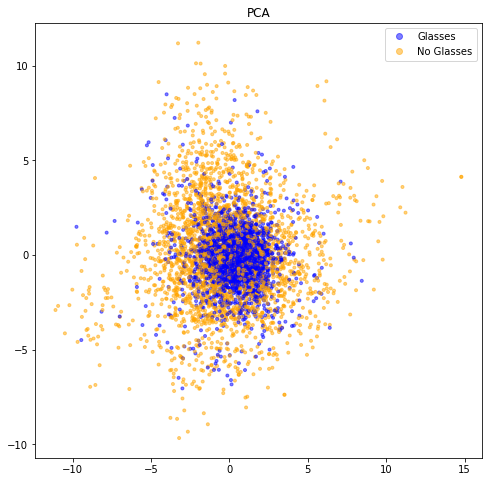

In [ ]:
dim_reduction_plot(reduced_X[:, 0], reduced_X[:, 1], Y, "PCA")

In [ ]:
X = np.array([np.array(x[0]) for x in preprocessed_df.orderBy("id", ascending=True).select("for_tsne_features").collect()])

from sklearn.manifold import TSNE
tsne_X = TSNE(n_components=2, perplexity=30, init="pca", random_state=seed, method="barnes_hut", n_jobs=-1).fit_transform(X)

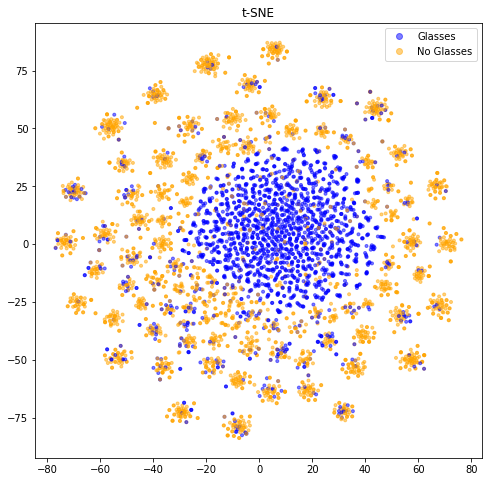

In [ ]:
dim_reduction_plot(tsne_X[:, 0], tsne_X[:, 1], Y, "t-SNE")

**<h4>Train/Test split</h4>**

We move to the usual `train/test split`: we shuffle the dataset and then randomly split it with a ratio of `0.8/0.2`, obtaining a train and a test dataframes.

---
The task we are going to perform is pretty heavy, especially if run on Colaboratory, thus the dataset size can be limited before moving forward.

In [ ]:
split = .2

from pyspark.sql.functions import rand
#preprocessed_df = preprocessed_df.limit(1000)            # tune this value to limit the dataset size to speed up the computation
preprocessed_df = preprocessed_df.orderBy(rand(seed))

train_df, test_df = preprocessed_df.select("features", "label").randomSplit([1-split, split], seed=seed)

In [ ]:
preprocessed_df.select("features", "label").limit(10).toPandas()

,features,label
0,"[0.47477, -0.63414, 0.80933, 0.26433, -0.17598...",1.0
1,"[-0.19482, 0.63085, -0.68047, 0.64795, 0.88233...",0.0
2,"[-0.56985, 0.2013, 0.12599, -1.33717, -0.91741...",0.0
3,"[-0.98726, 0.64769, -0.38543, -0.519, 0.18217,...",0.0
4,"[-0.182, 0.61906, 1.65054, -0.83818, -1.2399, ...",0.0
5,"[0.48458, -1.4548, -1.03043, 0.86894, -1.55374...",0.0
6,"[-0.24945, -0.16326, -0.95526, -0.31603, -0.43...",0.0
7,"[0.13431, 1.51305, 0.22272, 0.39916, 0.54427, ...",1.0
8,"[0.75067, 0.5617, 0.9769, -0.63982, 0.14152, 1...",0.0
9,"[0.55766, -1.08535, 0.09103, 0.1899, 0.76221, ...",0.0


**<h4>Standardization</h4>**

At this point we want to standardize the data, i.e. apply a transformation that makes all the features to be centered around 0 and have a variance of 1 (Pyspark uses the corrected sample standard deviation, thus the variance will not be exactly 1 for the majority of the features). In order to let the test set to be as untouched as we can, we will fit the scaler on the training set alone and then apply the trasformation on both the datasets.

In [ ]:
train_scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True).fit(train_df)

train_df = train_scaler.transform(train_df).select("scaled_features", "label")
test_df = train_scaler.transform(test_df).select("scaled_features", "label")

train_df = train_df.cache()
test_df = test_df.cache()

**<h4>Model</h4>**

These two functions are used to build a `Keras model` and an `Elephas Estimator`, respectively. An estimator is an algorithm that produces a `Transformer` after training on a DataFrame, while the Transformer can transform a DataFrame of features in a DataFrame of predictions. Elephas builds an Estimator from a Keras Model, giving the possibility to perform distributed deep learning. In particular, distribution is obtained by serializing the model, sending it to the workers, let them train their chunk and send gradients to the driver. A `master model` on the driver uses these gradients together with an optimizer in order to update its weights.

In [ ]:
from tensorflow.keras.models import Sequential
from elephas.ml_model import ElephasEstimator

def build_model(layers_list, optimizer="adam", loss="binary_crossentropy", metrics=["acc"]):
  model = Sequential()
  for layer in layers_list:
    model.add(layer)
  model.compile(optimizer, loss, metrics)
  return model


def build_estimator(model, epochs, batch_size, categorical, num_workers=1, loss="binary_crossentropy",
                    nb_classes=None, optimizer=tf.keras.optimizers.serialize(tf.keras.optimizers.Adam()), split=.2,
                    featuresCol="features", labelCol="label", metrics=["acc"], frequency="batch", mode="asynchronous", verbose=0):
  return ElephasEstimator(keras_model_config=model.to_json(), num_workers=num_workers, loss=loss, categorical=categorical,
                          nb_classes=nb_classes, optimizer_config=optimizer, validation_split=split, epochs=epochs, batch_size=batch_size,
                          featuresCol=featuresCol, labelCol=labelCol, metrics=metrics, frequency=frequency, mode=mode, verbose=verbose)   

This is the MLP we are going to train with our dataset. In our experiments (refer to [this notebook](https://github.com/flaviofuria/GlassesOrNoGlasses/blob/main/glasses_no_glasses.ipynb)) it has proven to give good performance and still being not so long to train. It's the best we were able to get with this dataset. Training on the actual images proved to be definitely better (refer to [this notebook](https://github.com/flaviofuria/GlassesOrNoGlasses/blob/main/pyspark_images.ipynb))

In [ ]:
num_features = len(train_df.select("scaled_features").first()[0])

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
layers_list = [Dense(16, activation="relu", input_shape=(num_features,)),
               Dropout(0.4, seed=seed),
               Dense(16, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=.00001, l2=.00001)),
               Dropout(0.3, seed=seed),
               Dense(1, activation="sigmoid")]

model = build_model(layers_list, optimizer=tf.keras.optimizers.Adam(1e-4))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 8,497
Trainable params: 8,497
Non-trainable params: 0
_________________________________________________________________


**<h4>Elephas Estimator</h4>**

We set some of the `hyperparameters` and then build the estimator. It takes the Keras model, together with these hyperparameters, the name of the features and labels columns of the training dataframe and three other parameters that actually control the distribution: 
* `frequency`, i.e. how often updates are sent to the master node. It can be done after every `batch` or `epoch`.
* `mode`, which can be `synchronous`, if workers send their updates all at the same time, `asynchronous` if they send updates whenever they are ready (locks are used to not lose any update) and `hogwild`, which is similar to the second one but without the locks (losing some updates is ok if this speeds the computation up). Asynchronous is our choice.
* the number of actual workers that will participate to the distributed training step.


In [ ]:
batch_size = 128
epochs = 120
optimizer=tf.keras.optimizers.serialize(tf.keras.optimizers.Adam(1e-4))

estimator = build_estimator(model=model, epochs=epochs, batch_size=batch_size, num_workers=4, featuresCol="scaled_features", mode="asynchronous", optimizer=optimizer, categorical=False)

**<h4>Fit/Transform Step</h4>**

We `fit` on the training set and then `transform` on both the training and test set, in order to obtain predictions. We capture the output because there is a lot of logging info that could cause Colab to crash.

In [ ]:
%%capture
fitted_model = estimator.fit(train_df)

In [ ]:
train_predictions = fitted_model.transform(train_df)
test_predictions = fitted_model.transform(test_df)

**<h4>Results</h4>**

We used a `sigmoid` activation function for the last layer, thus the prediction, which is a value in the unit interval, can be interpreted as the probability to be a positive sample (label 1.0). We give the label `1.0` to samples for which this value is greater than or equal to `0.5`, otherwise we give it `0.0`. The threshold is tunable but if the results are satisfying, we can leave it as is.

In [ ]:
from pyspark.sql.functions import when
train_predictions = train_predictions.withColumn("predicted_label", when(train_predictions.prediction[0] >= 0.5, 1.0).otherwise(0.0))
test_predictions = test_predictions.withColumn("predicted_label", when(test_predictions.prediction[0] >= 0.5, 1.0).otherwise(0.0))

train_predictions_rdd = train_predictions.select("predicted_label", "label").rdd.map(tuple)
test_predictions_rdd = test_predictions.select("predicted_label", "label").rdd.map(tuple)

from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
train_accuracy = MulticlassMetrics(train_predictions_rdd).accuracy
test_accuracy = MulticlassMetrics(test_predictions_rdd).accuracy

train_auc = BinaryClassificationMetrics(train_predictions_rdd).areaUnderROC
test_auc = BinaryClassificationMetrics(test_predictions_rdd).areaUnderROC

In [ ]:
print(f"Training accuracy: {round(train_accuracy, 4)}")
print(f"Training AUC:      {round(train_auc, 4)}")
print('')
print(f"Test accuracy:     {round(test_accuracy, 4)}")
print(f"Test AUC:          {round(test_auc, 4)}")

Training accuracy: 0.9252
Training AUC:      0.9205

Test accuracy:     0.8876
Test AUC:          0.881


Pyspark and Elephas do not allow us to get the loss, thus we will compute it on our own. The model has been trained using `binary crossentropy`/`log loss`:
$$Loss(y,p)=y_{i}*log(p_{i})+(1-y_{i})*log(1-p_{i})).\;\;$$ We compute this value for all samples and then we average it over the whole set.

---
We do the same also for `stable binary crossentropy`, which is the loss used by Tensorflow to avoid computing the logarithm when the predicted probability is too close to 0, which can lead to numerical instability:<br>
$$Loss(y,z)=max(z,0)-zy+log(1+e^{-|z|})\;\;$$ with `z` being the output of the network, thus we obtain it by computing the inverse of the sigmoid function (i.e. the `logit`).

In [ ]:
from pyspark.sql.functions import log, mean, abs, col
from functools import reduce
from math import e

def logit(p):
  return log(p/(1-p))

binary_crossentropy = reduce(lambda p,y: -(y*log(p[0]) + (1-y)*log(1-p[0])), map(col, ["prediction", "label"]))
stable_binary_crossentropy = reduce(lambda p,y: when(logit(p[0])>0, logit(p[0])).otherwise(0) - (logit(p[0])*y) + log(1+e**(-abs(logit(p[0])))), map(col, ["prediction", "label"]))

train_losses = train_predictions.withColumn("binary_crossentropy", binary_crossentropy)
train_stable_losses = train_predictions.withColumn("stable_binary_crossentropy", stable_binary_crossentropy)
test_losses = test_predictions.withColumn("binary_crossentropy", binary_crossentropy)
test_stable_losses = test_predictions.withColumn("stable_binary_crossentropy", stable_binary_crossentropy)

train_binary_crossentropy = train_losses.select("binary_crossentropy").agg(mean("binary_crossentropy"))
train_stable_binary_crossentropy = train_stable_losses.select("stable_binary_crossentropy").agg(mean("stable_binary_crossentropy"))
test_binary_crossentropy = test_losses.select("binary_crossentropy").agg(mean("binary_crossentropy"))
test_stable_binary_crossentropy = test_stable_losses.select("stable_binary_crossentropy").agg(mean("stable_binary_crossentropy"))

train_bin_cross = train_binary_crossentropy.take(1)[0][0]
train_stable_bin_cross = train_stable_binary_crossentropy.take(1)[0][0]
test_bin_cross = test_binary_crossentropy.take(1)[0][0]
test_stable_bin_cross = test_stable_binary_crossentropy.take(1)[0][0]

In [ ]:
print(f"Training set log loss:        {round(train_bin_cross, 4)}")
print(f"Stable training set log loss: {round(train_stable_bin_cross, 4)}")
print('')
print(f"Test set log loss:            {round(test_bin_cross, 4)}")
print(f"Stable test set log loss:     {round(test_stable_bin_cross, 4)}")

Training set log loss:        0.1916
Stable training set log loss: 0.1916

Test set log loss:            0.327
Stable test set log loss:     0.327


We don't have instability issues, thus the results are just the same. However, they're different from what we got in the non-distributed implementation. One of the reasons is of course that the the training/test set are not exactly the same, since in both cases we have shuffled the original dataset and then randomly splitted it. Also, the fact that every worker locally computes its gradients and then sends them to the master node, which in turn makes an overall computation with the received ones, could have led to some discrepancy.